In [1]:
import sys,os

sys.path.append('/home/arash/ProjectVR/')

import importlib
import deepsurv
import json
import time
import numpy as np
import pandas as pd
import pickle

import lasagne
import optunity

import logging
from logging import handlers
from sklearn.model_selection import train_test_split

importlib.reload(deepsurv)

from deepsurv import deep_surv, utils

from deepsurv.deepsurv_logger import DeepSurvLogger, TensorboardLogger

import shap  # package used to calculate Shap values
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtrain', 'rb') as f:
    xtrain=pickle.load(f)
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctrain', 'rb') as f:
    NCtrain=pickle.load(f)

network=deep_surv.load_model_from_json(model_fp = '/home/arash/ProjectVR/models/Deepwait100epochsTuned',
                     weights_fp = '/home/arash/ProjectVR/models/deepwait_weights_100_epochs.npz')

Loading json model: {"n_in": 19, "learning_rate": 0.0008208386784744157, "hidden_layers_sizes": [90, 90], "lr_decay": 0.000551240234375, "activation": "rectify", "dropout": 0.0, "batch_norm": true, "standardize": false}


In [7]:
#using train set for interpretability
dfxtrain=pd.DataFrame(xtrain[:,0:network.hyperparams['n_in']])
dfxtrain.columns=NCtrain.iloc[:,0:network.hyperparams['n_in']].columns

#seperate binary and continous variables:
binarycol = ['walktoshop','numcars_morethan1','mode_Car','over50','Age_18 - 29','Snowy',
           'Gender_Female', 'One way','mode-active', 'driving license_Yes', 'Mixed', 'Vrexp_Yes',
           'Age_30 - 39', 'FullAV','Night', 'walktowork']
contcol = ['normarrival','normdens','normlanewidth']

#using zeros as background data for binary variables, and mean value for cont variables
backgrounddata=pd.DataFrame(np.zeros(network.hyperparams['n_in'])).T         
backgrounddata.columns=NCtrain.iloc[:,0:network.hyperparams['n_in']].columns
backgrounddata[contcol]=[(dfxtrain['normarrival']).mean(),
                         (dfxtrain['normdens']).mean(),(dfxtrain['normlanewidth']).mean()] 


explainer = shap.KernelExplainer(network.predict_risk,backgrounddata)
shap_values = explainer.shap_values(dfxtrain)


  1%|          | 19/1832 [00:03<07:51,  3.85it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  2%|▏         | 28/1832 [00:05<06:57,  4.33it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  6%|▌         | 103/1832 [00:21<06:45,  4.26it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next v

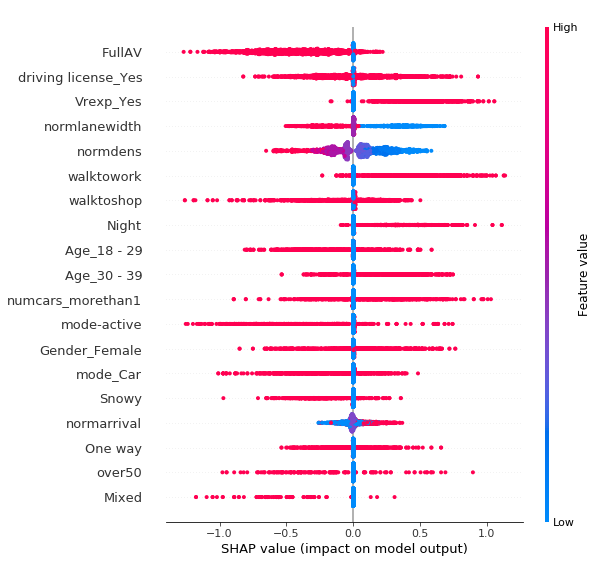

In [8]:
shap.summary_plot(shap_values[0], dfxtrain,max_display=20)

### Create Table of Shap Values for each feature

In [9]:
def greaterthanmean(col):
    ColMean=col.mean()
    BlueIndex=col[col<=ColMean].index     #indices of feature values less than (or eq to) avg of feature
    return BlueIndex

Blues = {'normarrival': greaterthanmean(dfxtrain['normarrival']),
         'normdens': greaterthanmean(dfxtrain['normdens']),
        'normlanewidth': greaterthanmean(dfxtrain['normlanewidth'])}


shap_df = pd.DataFrame(shap_values[0], copy = True)
shap_df.columns = dfxtrain.columns
shap_df['normarrival'][Blues['normarrival']] = shap_df['normarrival'][Blues['normarrival']]*(-1)
shap_df['normdens'][Blues['normdens']] = shap_df['normdens'][Blues['normdens']]*(-1)
shap_df['normlanewidth'][Blues['normlanewidth']] = shap_df['normlanewidth'][Blues['normlanewidth']]*(-1)





mean=shap_df[shap_df!=0].mean()              #mean of shap values for each feature (non-zeros only

nonzeros=shap_df.astype(bool).sum(axis=0)        #count of non-zeros shap values for each feature

std=shap_df[shap_df!=0].std()                #standard deviation of shap values for each feature

featuresshap=pd.DataFrame()

featuresshap['count']=nonzeros
featuresshap['mean']=mean                 #bg0: zeros set as background data

featuresshap['std']=std

featuresshap['absmean']=abs(mean)

featuresshap.sort_values(by=['absmean'])

,count,mean,std,absmean
driving license_Yes,1673,-0.009139,0.282783,0.009139
One way,622,-0.025618,0.202029,0.025618
normarrival,1822,0.040976,0.084102,0.040976
Gender_Female,788,0.041207,0.296673,0.041207
walktoshop,1317,-0.072150,0.267614,0.072150
numcars_morethan1,758,0.128527,0.308669,0.128527
Age_18 - 29,864,-0.150104,0.262451,0.150104
normdens,1832,-0.189283,0.134396,0.189283
normlanewidth,1827,-0.197178,0.174466,0.197178
mode_Car,607,-0.219578,0.288207,0.219578
